# Aufgabe 3: Data Preparation und Modeling 

In [237]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

In [238]:
random_seed = 123456789 # Random Seed für Modelle

In [239]:
dataset = pd.read_csv('./DatenAusgegeben1.0.csv', delimiter=';', encoding = 'cp852')
dataset

,Grundstück in qm,Grundstücksform,Steigung,Bezirk,Zone,Lage,Typ,Zustand,Gebaut,Renoviert,...,Schlafzimmer,Küchen,Küchenqualitt,Rume,Garage Typ,Garagenkapazitt,Pool,Verkaufsmonat,Verkaufsjahr,Preis
0,898,IR1,Nein,Somerset,RL,Norm,2Fam,4,2107,2107,...,6,2,3,10,Anbau,2,NaN,8,2136,156500
1,1326,Reg,Nein,North East,RL,Norm,1Fam,5,2133,2133,...,3,1,4,7,Anbau,3,NaN,1,2137,350000
2,725,Reg,Nein,Somerset,RL,Norm,1Fam,7,2096,2138,...,3,1,4,5,Freistehend,1,NaN,6,2140,137900
3,725,Reg,Nein,Somerset West,RL,Norm,1Fam,5,2135,2135,...,3,1,4,8,Anbau,2,NaN,4,2136,184000
4,697,Reg,Nein,Miller,RL,Norm,1Fam,5,2129,2129,...,3,1,4,7,Anbau,2,NaN,6,2140,189000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1272,IR1,Nein,North East,RL,Norm,1Fam,5,2133,2134,...,3,1,5,10,Eingebaut,3,NaN,3,2138,412500
1996,941,IR1,Nein,Miller,RL,Norm,1Fam,5,2134,2134,...,3,1,4,7,Anbau,2,NaN,7,2139,195500
1997,1093,Reg,Nein,Grand Park,RL,Norm,1Fam,7,2040,2130,...,2,1,3,6,Freistehend,1,NaN,5,2137,112000
1998,1228,IR1,Nein,North East,RL,Norm,1Fam,5,2134,2134,...,3,1,4,9,Eingebaut,3,NaN,2,2136,279000


## Unnötige Spalten entfernen
Zu entfernen sind:  
Siehe Aufg. 2. Untersuchung auf einen Zusammenhang zwischen Preis und Verkaufszeitpunkt:
- Verkaufsjahr
- Verkaufsmonat

(Da Gesamtwohnfläche zusammengesetzt aus erster Stock und zweiter Stock ist:
- Erster Stock in qm
- Zweiter Stock in qm
#TODO: Prüfen ob nicht rauszunehmen)

Siehe Aufg. 2. Untersuchung des Datensatzes auf vernachlässigbare Hauseigenschaften (Spalten):
- Pool
- Küchen
- Klimaanlage
- Heizung

In [240]:
df_keinunnoetig = dataset.drop(['Verkaufsjahr', 'Verkaufsmonat', 'Erster Stock in qm', 'Zweiter Stock in qm', 'Pool', 'Küchen', 'Klimaanlage', 'Heizung'], axis = 1)

## Anomalien bereinigen
Nun sollen Anomalien in dem Datensatz gefunden und bereinigt werden.
Hierbei wird der Interquartilsabstand verwendet um Ausreißer zu finden.  
(https://en.wikipedia.org/wiki/Interquartile_range)  

Hierbei sollen ausschließlich numerische Werte, also keine Werte einer ordinalen Skala betrachtet werden. (`columns_filtered`)

Bereits in Aufgabe 2 erkannte und zu bereinigende Anomalien sind:
- Bezirksname `Somerst` anstatt `Somerset`
- Ausreißer im Datensatz

In [241]:
df_keinunnoetig['Bezirk'] = df_keinunnoetig['Bezirk'].replace('Somerst', 'Somerset') # Bezirksname korrigieren

columns = ['Grundstück in qm', 'Zustand', 'Gebaut',
           'Renoviert', 'Zustand Fassade', 'Kellerflche in qm',
           'Wohnflche in qm', 'Schlafzimmer', 'Küchenqualitt', 
           'Rume', 'Garagenkapazitt', 'Preis']

columns_filtered = ['Grundstück in qm', 'Kellerflche in qm', 'Wohnflche in qm', 
           'Schlafzimmer', 'Gebaut', 'Rume', 'Garagenkapazitt', 'Preis']

Q1 = df_keinunnoetig[columns_filtered].quantile(0.25)
Q3 = df_keinunnoetig[columns_filtered].quantile(0.75)
IQR = Q3 - Q1 # Interquartilsabstand berechnen

df_anomalienbereinigen = df_keinunnoetig[~((df_keinunnoetig[columns_filtered] < (Q1 - 1.5 * IQR)) | (dataset[columns_filtered] > (Q3 + 1.5 * IQR))).any(axis=1)] # Anomalien außerhalb des Interquartilsabstands entfernen

## Verifikation der Bereinigung
Nun soll verifiziert werden, ob die Bereinigung auf Anomalien erfolgreich gewesen ist. Hierzu können die untenstehenden Boxplots mit denen aus **Aufg. 2, Finden von Anomalien** verglichen werden.

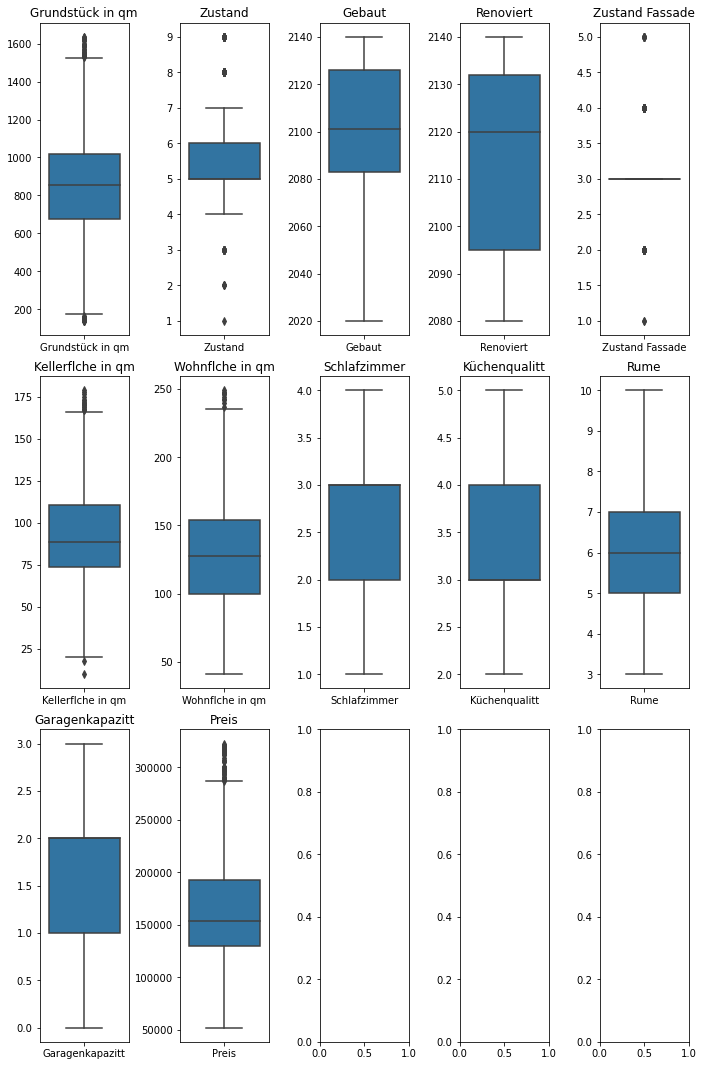

In [242]:
fig, axes = plt.subplots(3, 5, figsize = (10, 15))
i = 0
plt.tight_layout(pad = 2)
for column in columns:
  chosenax = axes[math.floor(i / 5)][i % 5]
  chosenax.set_title(column)
  sb.boxplot(data = df_anomalienbereinigen[[column]], ax = chosenax)
  i = i + 1
plt.show()

## Feature Engineering
Folgend soll das One-Hot Encoding auf alle geeigneten Kategorien angewendet werden.

Den Bezirken ist ein weiterer Bezirk, `Finger River` hinzuzufügen, welcher in der Datenbeschreibung, jedoch nicht im Datensatz vorhanden ist.

In [243]:
encode_kategorien = ['Bezirk', 'Lage', 'Heizungsqualitt', 'Typ', 'Steigung', 'Grundstücksform', 'Garage Typ', 'Zone']

encoded_kategorieeigenschaften = pd.get_dummies(dataset[encode_kategorien].fillna('Keine'))
encoded_kategorieeigenschaften['Bezirk_Finger River'] = 0
df_encoded = df_anomalienbereinigen.drop(encode_kategorien, axis = 1).join(encoded_kategorieeigenschaften)

print(df_encoded)

      Grundstück in qm  Zustand  Gebaut  Renoviert  Zustand Fassade  \
2                  725        7    2096       2138                3   
3                  725        5    2135       2135                3   
4                  697        5    2129       2129                3   
5                 1274        5    2080       2080                3   
7                  211        5    2133       2134                3   
...                ...      ...     ...        ...              ...   
1994               948        8    2070       2127                3   
1996               941        5    2134       2134                3   
1997              1093        7    2040       2130                3   
1998              1228        5    2134       2134                3   
1999               778        7    2071       2103                3   

      Kellerflche in qm  Wohnflche in qm  Schlafzimmer  Küchenqualitt  Rume  \
2                    80               83             3              

## Aufspaltung nach Trainings- und Validierungsset

In [244]:
df_train = df_encoded.drop('Preis', axis = 1)
values_predict = df_encoded['Preis']
x_train, x_test, y_train, y_test = train_test_split(df_train, values_predict, test_size = 0.2, random_state = random_seed)

## Lineare Regression

In [245]:
reg1 = LinearRegression()
reg1.fit(x_train, y_train)

LinearRegression()

## Random Forest
Finden von optimalen Parametern mithilfe von Gridsearch und 5-fold Crossvalidation

In [246]:
RFR=RandomForestRegressor(random_state = random_seed)

search_grid_rfr = {'n_estimators': [100,200,300,400,500,1000], 'max_features': ['auto', 'sqrt']}

search = GridSearchCV(estimator = RFR, param_grid = search_grid_rfr, n_jobs = -1, cv = 5, verbose = 8)

search.fit(x_train, y_train)
print("Bestes gefundenes Modell:", search.best_estimator_)
print("Bester CV Score:", search.best_score_)
reg2 = search.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  45 out of  60 | elapsed:   13.3s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  53 out of  60 | elapsed:   16.8s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   18.8s finished
Bestes gefundenes Modell: RandomForestRegressor(n_estimators=400, random_state=123456789)
Bester CV Score: 0.8748802872413766


## Gradient Boosting
Ebenso finden von optimalen Parametern mithilfe von Gridsearch und 5-fold Crossvalidation

In [247]:
GBR=GradientBoostingRegressor(random_state = random_seed)

search_grid_gbr = {'n_estimators':[100,500,1000], 'learning_rate':[0.01,0.05,.1], 'max_depth':[2,3,4,5]}

search=GridSearchCV(estimator = GBR, param_grid = search_grid_gbr, n_jobs = -1, cv = 5, verbose = 8)

search.fit(x_train, y_train)
print("Bestes gefundenes Modell:", search.best_estimator_)
print("Bester CV Score:", search.best_score_)
reg3 = search.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   31.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   31.6s finished
Bestes gefundenes Modell: GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=1000,
                          random_state=123456789)
Bester CV Score: 0.8956231722043929


## Vergleichen der Modelle (R^2)
Folgend werden die Modelle anhand der R^2 Metrik verglichen.  
Hierbei wird sowohl die R^2 Metrik der Anwendung des Modells auf den Trainings-Datensatz, als auch die R^2 Metrik bei einer Anwendung auf den Test-Datensatz verglichen. Durch diesen Vergleich soll eventuelles Over-/Underfitting erkannt werden.

In [248]:
print("Modell\t\t\t\t","Training","\t\t","Test")
print("Linear Regression\t\t", reg1.score(x_train, y_train), "\t", reg1.score(x_test, y_test))
print("Random Forest Regression\t", reg2.score(x_train, y_train), "\t", reg2.score(x_test, y_test))
print("Gradient Boosting Regression\t", reg3.score(x_train, y_train), "\t", reg3.score(x_test, y_test))

Modell				 Training 		 Test
Linear Regression		 0.8946771744808966 	 0.8920920539619288
Random Forest Regression	 0.9835364932952899 	 0.8870579855044514
Gradient Boosting Regression	 0.9496137120559751 	 0.903655330979769


### Erkenntnis
Wie in der obigen Ausgabe zu sehen overfittet lediglich die `Random Forest Regression`.  
Alle drei Modelle erzielen dennoch eine gute Performance.

## Visueller Vergleich der Modelle
Um die Modelle visuell zu vergleichen wird folgend zunächst der Testdatensatz zusammen mit den vorhergesagten Preisen aufsteigend sortiert um eine bessere Visualisierung zu ermöglichen. Daraufhin werden die Regressionsmodelle visuell verglichen. 

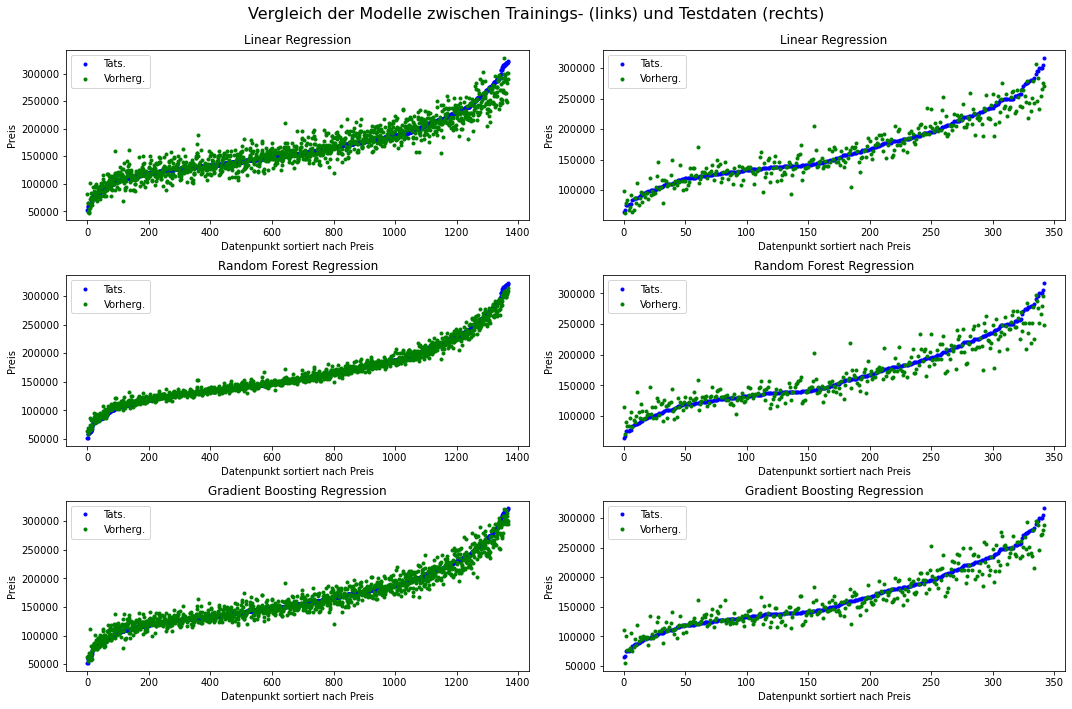

In [249]:

plt.figure(figsize = (15, 10))

i = 1
for reg in [(reg1, 'Linear Regression'), (reg2, 'Random Forest Regression'), (reg3, 'Gradient Boosting Regression')]:
    y_pred = reg[0].predict(x_test)
    y_test_sort, y_pred_sort = zip(*sorted(zip(y_test, y_pred))) ## Synchrones aufsteigendes sortieren nach Preis
    plt.subplot(3,2,i * 2)
    i = i + 1
    plt.plot(range(0, len(y_test_sort)), y_test_sort, 'b.', label = 'Tats.')
    plt.plot(range(0, len(y_pred_sort)), y_pred_sort, 'g.', label = 'Vorherg.')
    plt.xlabel('Datenpunkt sortiert nach Preis')
    plt.ylabel('Preis')
    plt.legend(loc = 'upper left')
    plt.title(reg[1])

i = 1
for reg in [(reg1, 'Linear Regression'), (reg2, 'Random Forest Regression'), (reg3, 'Gradient Boosting Regression')]:
    y_pred = reg[0].predict(x_train)
    y_test_sort, y_pred_sort = zip(*sorted(zip(y_train, y_pred))) ## Synchrones aufsteigendes sortieren nach Preis
    plt.subplot(3,2,i * 2 - 1)
    i = i + 1
    plt.plot(range(0, len(y_test_sort)), y_test_sort, 'b.', label = 'Tats.')
    plt.plot(range(0, len(y_pred_sort)), y_pred_sort, 'g.', label = 'Vorherg.')
    plt.xlabel('Datenpunkt sortiert nach Preis')
    plt.ylabel('Preis')
    plt.legend(loc = 'upper left')
    plt.title(reg[1])

plt.suptitle("Vergleich der Modelle zwischen Trainings- (links) und Testdaten (rechts)", fontsize = 16)
plt.tight_layout()
plt.subplots_adjust(top = 0.92)
plt.show()

### Erkenntnis
Aus den oben gezeigten Plots und dem Vergleich der R^2 Metrik zeigt sich, dass alle drei Modelle sehr genau in der Vorhersage arbeiten, jedoch die `Gradient Boosting Regression` wie erwartet, da zum jetzigen Zeitpunkt State of the Art, die besten Ergebnisse liefert. Zudem zeigt sich, dass sich die `Random Forest Regression` sehr stark an den Trainingsdatensatz angleicht.

Daher wählen wir als finales Modell die `Gradient Boosting Regression`.

## Erklärung und Interpretation der Linearen Regression

In [250]:
print("Y-Achsenabschnitt:", reg1.intercept_)
print("\nKoeffizienten:")
for i in range(0, len(reg1.coef_)):
    print(x_train.columns[i] + ":", reg1.coef_[i])

Y-Achsenabschnitt: -1198126.9030308886

Koeffizienten:
Grundstück in qm: 16.50733045055129
Zustand: 7027.106335198403
Gebaut: 461.35790117311774
Renoviert: 85.53833599633754
Zustand Fassade: -203.3624886956286
Kellerflche in qm: 329.2765853721718
Wohnflche in qm: 617.6738199853504
Schlafzimmer: -4499.75812830541
Küchenqualitt: 8327.512500988822
Rume: -437.53171257183385
Garagenkapazitt: 10748.804447234743
Bezirk_Burnley: -12101.720965937337
Bezirk_ChinaTown: -5991.446024807879
Bezirk_City Hall: 16882.884751118338
Bezirk_Clear Creek: -2553.0188389378436
Bezirk_DiamondDistrict: 14622.89748453641
Bezirk_Dixon Side: 2653.4973039852575
Bezirk_East End: 19909.53393564159
Bezirk_Fashion District: 13633.657669387405
Bezirk_Grand Park: -14977.510581714065
Bezirk_Miller: -9598.722690894023
Bezirk_New Gotham: -12514.609155523069
Bezirk_North East: 17059.708219936918
Bezirk_North West: -13383.387028768182
Bezirk_Novick District: 9065.47240172433
Bezirk_Old Gotham: -7041.862683584944
Bezirk_Paris I

### Erklärung
Der Grundwert einer Immobilie beträgt etwa -1,2 Millionen Gotham Dollars.  
Hierzu werden nun den Eigenschaften und Größen zugeordnete Gotham Dollar Einheiten dazuaddiert.
   
Beispiel:
- Grundstück: 500qm
- Zustand: 6
- Gebaut: Jahr 2080
- Renoviert: Jahr 2100
- Wohnfläche: 80 qm
- Bezirk: China Town
- ...

Beispielrechnung:  
`-1.198.127 + (500 * 17) + (6 * 7027) + (2080 * 461) + (2100 * 86) + (80 * 618) + (1 * (-5991)) + ... = ...`

So addiert sich dies zusammen bis man den finalen Immobilienpreis erhält.

## Export des Gradient Boosting Modells

In [252]:
from joblib import dump
dump(reg3, 'gradientboosted.model')

['gradientboosted.model']